### 1. Library Import 

In [2]:
import pandas as pd
import re
import unicodedata 
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as STOP_FR
from spacy.lang.en.stop_words import STOP_WORDS as STOP_EN
from langdetect import detect

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt

import requests
import time

import threading

import os
import pickle
import numpy as np


### 2. Data Import

In [15]:
df=pd.read_csv('CAIRN_real_final_chunks.csv')

### 3. Data manipulation

#### 3.a Language detection

In [26]:
def detect_lang_extended(text):
    try:
        lang = detect(text)
    except:
        return "other"     

    if lang in ("fr", "en"):
        return lang
    else:
        return "other"  

In [27]:
df["langue"] = df["chunk_clean"].apply(detect_lang_extended)

In [29]:
def count_languages(lang_series):
    counts = lang_series.value_counts(dropna=False).to_dict()
    return {
        "fr": counts.get("fr", 0),
        "en": counts.get("en", 0),
        "other": counts.get("other", 0)
    }
resultats = count_languages(df["langue"])
print(resultats)

{'fr': 99191, 'en': 1310, 'other': 760}


In [30]:
df_filtered = df[df["langue"].isin(["fr", "en"])]

In [31]:
df_filtered.to_csv("CAIRN_chunks_en_and_fr.csv", index=False, encoding="utf-8")

#### 3.b Data simple cleaning 

In [32]:
def clean_text_for_lda(text: str) -> str:
    import re, unicodedata

    text = text.lower()
    text = unicodedata.normalize("NFC", text)
    text = text.replace("’", "'")
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[!?:;,.\(\)\[\]\{\}«»\"…]", " ", text)
    text = re.sub(r"(?<!\w)-(?!\w)", " ", text)
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"[^a-zàâäçéèêëîïôöùûüÿœæ_ ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [33]:
df_filtered["chunk_clean"] = df_filtered["chunk"].apply(clean_text_for_lda)

/var/folders/tt/y9bw1l4d3qj30pkppbrwz1v40000gn/T/ipykernel_73826/1257117449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["chunk_clean"] = df_filtered["chunk"].apply(clean_text_for_lda)


#### 3.c Tokenization, lemmatization and removing stopwords 

In [42]:
nlp_fr = spacy.load("fr_core_news_md")
nlp_en = spacy.load("en_core_web_md")


def tokenize_lemmatize_multilang_batch(texts, langs, batch_size=50):
    """
    Batch tokenization & lemmatization for a list of texts.
    Uses spaCy's nlp.pipe for high performance.
    'texts' : list of strings
    'langs' : list of 'fr' or 'en'
    """
    
    # Separate texts by language  
    fr_indices = [i for i, l in enumerate(langs) if l == "fr"]
    en_indices = [i for i, l in enumerate(langs) if l == "en"]

    fr_texts = [texts[i] for i in fr_indices]
    en_texts = [texts[i] for i in en_indices]

    # storage
    results = [None] * len(texts)

    # --- French batch processing ---
    for doc, idx in zip(nlp_fr.pipe(fr_texts, batch_size=batch_size), fr_indices):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and token.lemma_.lower() not in STOP_FR
            and len(token.lemma_) > 2
        ]
        results[idx] = tokens

    # --- English batch processing ---
    for doc, idx in zip(nlp_en.pipe(en_texts, batch_size=batch_size), en_indices):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and token.lemma_.lower() not in STOP_EN
            and len(token.lemma_) > 2
        ]
        results[idx] = tokens

    return results


In [47]:
texts = df_filtered["chunk_clean"].tolist()
langs = df_filtered["langue"].tolist()

df_filtered["tokens"] = tokenize_lemmatize_multilang_batch(
    texts, langs, batch_size=50
)


/var/folders/tt/y9bw1l4d3qj30pkppbrwz1v40000gn/T/ipykernel_73826/953943226.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tokens"] = tokenize_lemmatize_multilang_batch(


In [48]:
display (df_filtered)

,url,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,page_fin,doi,pdf_url,type_document,variante_recherchee,name,chunk,chunk_clean,langue,tokens
0,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,NaN,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,L ’histoire du premier demi-siècle de l’inté­g...,l histoire du premier demi siècle de l inté gr...,fr,"[histoire, demi, siècle, inter, gration, europ..."
1,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,NaN,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,"Dans un cas, l’un des facteurs de crise fut l’...",dans un cas l un des facteurs de crise fut l a...,fr,"[cas, facteur, crise, autoritarisme, excessif,..."
2,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,NaN,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,Ce sont des États nouvellement adhérents qui o...,ce sont des états nouvellement adhérents qui o...,fr,"[état, nouvellement, adhérent, ouvrir, voie, d..."
3,https://droit.cairn.info/abecedaire-de-droit-d...,Solidarité,Isabelle Bosse-Platière,NaN,summary,NaN,2017.0,NaN,507,519,10.3917/pur.bosse.2017.01.0507,NaN,Chapitre d’ouvrage,Catherine 2 de Russie,Catherine II de Russie,"E n juin 2015, j’ai prononcé, devant un parter...",e n juin j ai prononcé devant un parterre de c...,fr,"[juin, prononcer, parterre, collègue, étudiant..."
4,https://droit.cairn.info/abecedaire-de-droit-d...,Solidarité,Isabelle Bosse-Platière,NaN,summary,NaN,2017.0,NaN,507,519,10.3917/pur.bosse.2017.01.0507,NaN,Chapitre d’ouvrage,Catherine 2 de Russie,Catherine II de Russie,"Tout d’abord, en dépit de ses multiples facett...",tout d abord en dépit de ses multiples facette...,fr,"[dépit, multiple, facette, enjeu, stratégique,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101256,https://stm.cairn.info/violences-de-la-maladie...,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,68,NaN,NaN,Chapitre d’ouvrage,F. Dostoievski,Fiodor Dostoïevski,Le sujet est ramené à lui-même par le biais d’...,le sujet est ramené à lui même par le biais d ...,fr,"[sujet, ramener, luire, biais, artifice, média..."
101257,https://stm.cairn.info/violences-de-la-maladie...,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,68,NaN,NaN,Chapitre d’ouvrage,F. Dostoievski,Fiodor Dostoïevski,La logique de la maladie est souvent celle de ...,la logique de la maladie est souvent celle de ...,fr,"[logique, maladie, dégradation, progressif, to..."
101258,https://stm.cairn.info/vulnerabilites-diversit...,"Chapitre 2.9. Santé des personnes transgenres,...",Denise Medico,NaN,summary,NaN,2022.0,NaN,361,371,10.3917/mh.boden.2022.01.0361,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,C e chapitre présente les prises en charge néc...,c e chapitre présente les prises en charge néc...,fr,"[chapitre, présente, prise, charge, nécessaire..."
101259,https://stm.cairn.info/vulnerabilites-diversit...,"Chapitre 2.9. Santé des personnes transgenres,...",Denise Medico,NaN,summary,NaN,2022.0,NaN,361,371,10.3917/mh.boden.2022.01.0361,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,Il vaut mieux ne pas laisser entendre que cel...,il vaut mieux ne pas laisser entendre que cela...,fr,"[valoir, mieux, entendre, celer, passer, proba..."


### 4. LDA

#### 4.a Topic number selection - using coherence

Max 10 topics

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104f22130>>
Traceback (most recent call last):
  File "/Users/angele/.pyenv/versions/3.9.6/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


✓ State loaded: lda_state.pkl


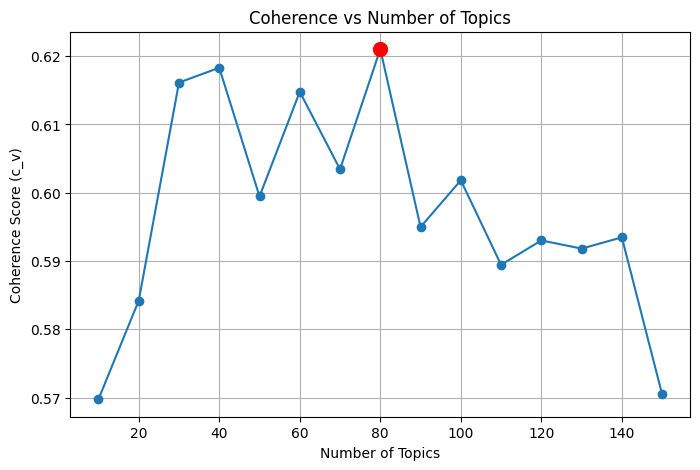

Meilleur: 80 topics (score: 0.6210)


In [7]:
# ----------------------------
# 1. Prepare dictionary and corpus
# ----------------------------
texts = df_filtered["tokens"].tolist()
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

# ----------------------------
# 2. Test topic numbers 3 → 10
# ----------------------------
topic_range = range(3, 10)
coherence_scores = []

for k in topic_range:
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        random_state=42,
        chunksize=2000
    )
    
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    score = cm.get_coherence()
    coherence_scores.append(score)
    print(f"Topics={k} → Coherence={score:.4f}")

# ----------------------------
# 3. Plot coherence
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics")
plt.grid(True)
plt.show()

# ----------------------------
# 4. Select best number of topics
# ----------------------------
best_k = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"\nBest number of topics = {best_k}")


max 100 topics

In [5]:
# ============================================================================
# BLOCK 1: UTILITY FUNCTIONS
# ============================================================================

def save_state(state, filename='lda_state.pkl'):
    """Save current processing state"""
    try:
        with open(filename, 'wb') as f:
            pickle.dump(state, f)
        print(f"✓ State saved: {filename}")
        return True
    except Exception as e:
        print(f"✗ Error saving state: {e}")
        return False

def load_state(filename='lda_state.pkl'):
    """Load saved state if exists"""
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                state = pickle.load(f)
            print(f"✓ State loaded: {filename}")
            return state
        return None
    except Exception as e:
        print(f"✗ Error loading state: {e}")
        return None

print("="*80)
print("BLOCK 1 COMPLETED: Utility functions loaded")
print("="*80)

BLOCK 1 COMPLETED: Utility functions loaded


In [66]:
# ============================================================================
# BLOCK 2: DATA PREPARATION
# ============================================================================
print("="*80)
print("BLOCK 2: DATA PREPARATION")
print("="*80)

# Check for existing state
existing_state = load_state()

if existing_state and 'corpus' in existing_state:
    print("Loading existing data...")
    dictionary = existing_state['dictionary']
    corpus = existing_state['corpus']
    texts = existing_state['texts']
else:
    print("Preparing new data...")
    texts = df_filtered["tokens"].tolist()
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Save state
    save_state({
        'dictionary': dictionary,
        'corpus': corpus,
        'texts': texts
    })

print(f"✓ Number of documents: {len(corpus)}")
print(f"✓ Dictionary size: {len(dictionary)}")
print("="*80)
print("BLOCK 2 COMPLETED: Data prepared")
print("="*80)

BLOCK 2: DATA PREPARATION
Preparing new data...
✓ State saved: lda_state.pkl
✓ Number of documents: 100501
✓ Dictionary size: 100000
BLOCK 2 COMPLETED: Data prepared


In [67]:
# ============================================================================
# BLOCK 3: FINDING OPTIMAL NUMBER OF TOPICS
# ============================================================================
print("="*80)
print("BLOCK 3: FINDING OPTIMAL NUMBER OF TOPICS")
print("="*80)

# Define topic list to test (your specific values)
topic_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
coherence_scores = []

# Resume if possible
existing_state = load_state()
if existing_state and 'coherence_scores' in existing_state:
    coherence_scores = existing_state['coherence_scores']
    dictionary = existing_state['dictionary']
    corpus = existing_state['corpus']
    texts = existing_state['texts']
    
    # Check if we already tested some of these values
    if 'tested_topics' in existing_state:
        tested_topics = existing_state['tested_topics']
        print(f"Resuming from {len(tested_topics)} completed tests")
        
        # Find where to resume
        start_idx = 0
        for idx, k in enumerate(topic_list):
            if k not in tested_topics:
                start_idx = idx
                break
    else:
        print("Starting new topic search...")
        start_idx = 0
else:
    start_idx = 0
    print("Starting new topic search...")

# Test different numbers of topics
for idx in range(start_idx, len(topic_list)):
    k = topic_list[idx]
    
    print(f"\nTesting {k} topics ({idx+1}/{len(topic_list)})...")
    
    # Create LDA model
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        random_state=42,
        chunksize=2000
    )
    
    # Calculate coherence
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    score = cm.get_coherence()
    coherence_scores.append(score)
    
    print(f"  Coherence score: {score:.4f}")
    
    # Save state after each model
    state_to_save = {
        'dictionary': dictionary,
        'corpus': corpus,
        'texts': texts,
        'coherence_scores': coherence_scores,
        'last_k': k,
        'tested_topics': topic_list[:idx+1]
    }
    save_state(state_to_save)

print("\n" + "="*80)
print("SUMMARY OF TESTED MODELS:")
print("="*80)
for i, k in enumerate(topic_list[:len(coherence_scores)]):
    print(f"  {k} topics → Coherence: {coherence_scores[i]:.4f}")

print("="*80)
print("BLOCK 3 COMPLETED: Topic search finished")
print("="*80)

BLOCK 3: FINDING OPTIMAL NUMBER OF TOPICS
✓ State loaded: lda_state.pkl
Starting new topic search...

Testing 10 topics (1/15)...
  Coherence score: 0.5698
✓ State saved: lda_state.pkl

Testing 20 topics (2/15)...
  Coherence score: 0.5842
✓ State saved: lda_state.pkl

Testing 30 topics (3/15)...
  Coherence score: 0.6161
✓ State saved: lda_state.pkl

Testing 40 topics (4/15)...
  Coherence score: 0.6183
✓ State saved: lda_state.pkl

Testing 50 topics (5/15)...
  Coherence score: 0.5994
✓ State saved: lda_state.pkl

Testing 60 topics (6/15)...
  Coherence score: 0.6148
✓ State saved: lda_state.pkl

Testing 70 topics (7/15)...
  Coherence score: 0.6034
✓ State saved: lda_state.pkl

Testing 80 topics (8/15)...
  Coherence score: 0.6210
✓ State saved: lda_state.pkl

Testing 90 topics (9/15)...
  Coherence score: 0.5950
✓ State saved: lda_state.pkl

Testing 100 topics (10/15)...
  Coherence score: 0.6018
✓ State saved: lda_state.pkl

Testing 110 topics (11/15)...
  Coherence score: 0.5894


In [68]:
# ----------------------------
# 4. Select best number of topics
# ----------------------------
best_k = topic_list[coherence_scores.index(max(coherence_scores))]
print(f"\nBest number of topics = {best_k}")


Best number of topics = 80


✓ State loaded: lda_state.pkl


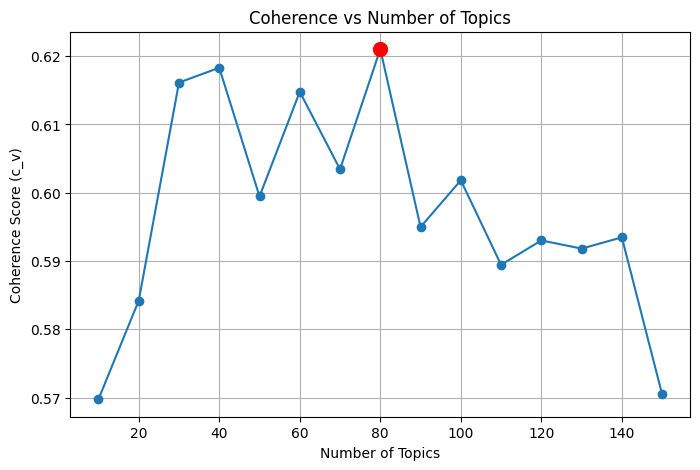

Meilleur: 80 topics (score: 0.6210)


In [8]:
state = load_state()
if state and 'coherence_scores' in state:
    scores = state['coherence_scores']
    topics = state.get('tested_topics', list(range(10, 151, 10)))[:len(scores)]
    
    plt.figure(figsize=(8,5))
    plt.plot(topics, scores, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.title("Coherence vs Number of Topics")
    plt.grid(True)
    
    # Marquer le meilleur
    best_idx = scores.index(max(scores))
    plt.scatter(topics[best_idx], scores[best_idx], color='red', s=100, zorder=5)
    
    plt.show()
    
    print(f"Meilleur: {topics[best_idx]} topics (score: {scores[best_idx]:.4f})")
else:
    print("Pas de résultats")

#### 4.b LDA using best_k

In [16]:
import pandas as pd
df_filtered=pd.read_csv("CAIRN_chunks_en_and_fr.csv", encoding="utf-8")

In [10]:
dictionary = state["dictionary"]
corpus = state["corpus"]
texts = state["texts"]
coherence_scores = state["coherence_scores"]

# Train final LDA model on full corpus
lda_final = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_k,
    passes=20,
    random_state=42,
    chunksize=2000
)

print("Final LDA model trained successfully.")

# ============================================================================
# Create columns with topics for each line of the DataFrame
# ============================================================================

# Assuming your DataFrame is named df and has a text column already processed as corpus lines
# If df is stored separately, load it here
# Example: df = pd.read_csv("your_file.csv")

all_topics_list = []
top2_topics_list = []

for doc_topics in lda_final.get_document_topics(corpus, minimum_probability=0):
    # Store all topics and weights
    all_topics_list.append(doc_topics)
    
    # Sort topics by probability
    top2 = sorted(doc_topics, key=lambda x: x[1], reverse=True)[:2]
    top2_topics_list.append(top2)


Final LDA model trained successfully.


NameError: name 'df' is not defined

In [17]:
import pandas as pd
# Add to DataFrame
df_filtered["all_topics"] = all_topics_list
df_filtered["top2_topics"] = top2_topics_list

print("\nNew columns added to DataFrame: 'all_topics' and 'top2_topics'")
print("="*80)
print("BLOCK 4 COMPLETED")
print("="*80)


New columns added to DataFrame: 'all_topics' and 'top2_topics'
BLOCK 4 COMPLETED


In [19]:
# ============================================================================
# SAVE RESULTS TO NEW CSV
# ============================================================================

output_file = "CAIRN_chunks_topics.csv"
df_filtered.to_csv(output_file, index=False, encoding='utf-8')

print(f"Fichier exporté avec succès : {output_file}")

Fichier exporté avec succès : CAIRN_chunks_topics.csv


In [22]:

top4_topics_list = []

for doc_topics in lda_final.get_document_topics(corpus, minimum_probability=0):

    # Sort topics by probability
    top4 = sorted(doc_topics, key=lambda x: x[1], reverse=True)[:4]
    top4_topics_list.append(top4)


In [23]:
df_filtered2 = pd.read_csv("CAIRN_chunks_topics.csv", encoding="utf-8")
df_filtered2["top4_topics"] = top4_topics_list

In [24]:
display(df_filtered2)

,url,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,page_fin,...,pdf_url,type_document,variante_recherchee,name,chunk,chunk_clean,langue,all_topics,top2_topics,top4_topics
0,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,...,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,L ’histoire du premier demi-siècle de l’inté­g...,l histoire du premier demi siècle de l inté gr...,fr,"[(0, 1.9593566e-05), (1, 1.9593566e-05), (2, 1...","[(54, 0.31510547), (39, 0.1455266)]","[(54, 0.3151011), (39, 0.14552729), (64, 0.099..."
1,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,...,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,"Dans un cas, l’un des facteurs de crise fut l’...",dans un cas l un des facteurs de crise fut l a...,fr,"[(0, 1.8078457e-05), (1, 0.0316559), (2, 1.807...","[(54, 0.31436336), (64, 0.16551836)]","[(54, 0.31430405), (64, 0.16555226), (39, 0.13..."
2,https://droit.cairn.info/Union-europeenne-dans...,Les obstacles structurels et les crises de cro...,Jean-Louis Quermonne,Science politique,summary,La Bibliothèque du citoyen,2008.0,NaN,67,81,...,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,Ce sont des États nouvellement adhérents qui o...,ce sont des états nouvellement adhérents qui o...,fr,"[(0, 6.842577e-05), (1, 6.842577e-05), (2, 6.8...","[(54, 0.38413316), (64, 0.15862206)]","[(54, 0.38313532), (64, 0.15825474), (39, 0.08..."
3,https://droit.cairn.info/abecedaire-de-droit-d...,Solidarité,Isabelle Bosse-Platière,NaN,summary,NaN,2017.0,NaN,507,519,...,NaN,Chapitre d’ouvrage,Catherine 2 de Russie,Catherine II de Russie,"E n juin 2015, j’ai prononcé, devant un parter...",e n juin j ai prononcé devant un parterre de c...,fr,"[(0, 2.0740681e-05), (1, 0.002817271), (2, 2.0...","[(54, 0.27882797), (46, 0.12575027)]","[(54, 0.27678564), (46, 0.123803705), (66, 0.1..."
4,https://droit.cairn.info/abecedaire-de-droit-d...,Solidarité,Isabelle Bosse-Platière,NaN,summary,NaN,2017.0,NaN,507,519,...,NaN,Chapitre d’ouvrage,Catherine 2 de Russie,Catherine II de Russie,"Tout d’abord, en dépit de ses multiples facett...",tout d abord en dépit de ses multiples facette...,fr,"[(0, 1.9897765e-05), (1, 1.9897765e-05), (2, 1...","[(54, 0.27460074), (46, 0.16694988)]","[(54, 0.27460048), (46, 0.16668816), (36, 0.10..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100496,https://stm.cairn.info/violences-de-la-maladie...,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,68,...,NaN,Chapitre d’ouvrage,F. Dostoievski,Fiodor Dostoïevski,Le sujet est ramené à lui-même par le biais d’...,le sujet est ramené à lui même par le biais d ...,fr,"[(0, 2.1687389e-05), (1, 2.1687389e-05), (2, 2...","[(20, 0.3168784), (19, 0.17985415)]","[(20, 0.31687236), (19, 0.17985079), (34, 0.16..."
100497,https://stm.cairn.info/violences-de-la-maladie...,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,68,...,NaN,Chapitre d’ouvrage,F. Dostoievski,Fiodor Dostoïevski,La logique de la maladie est souvent celle de ...,la logique de la maladie est souvent celle de ...,fr,"[(0, 5.1936957e-05), (1, 5.1936957e-05), (2, 5...","[(20, 0.45328182), (34, 0.10879275)]","[(20, 0.45326182), (34, 0.108861476), (31, 0.0..."
100498,https://stm.cairn.info/vulnerabilites-diversit...,"Chapitre 2.9. Santé des personnes transgenres,...",Denise Medico,NaN,summary,NaN,2022.0,NaN,361,371,...,NaN,Chapitre d’ouvrage,Grossman,Vassili Grossman,C e chapitre présente les prises en charge néc...,c e chapitre présente les prises en charge néc...,fr,"[(0, 2.1562617e-05), (1, 2.1562617e-05), (2, 0...","[(50, 0.19686778), (19, 0.15467092)]","[(50, 0.19686975), (19, 0.15467

In [20]:
# ============================================================================
# DISPLAY ALL TOPICS (TOP WORDS FOR EACH TOPIC)
# ============================================================================

print("\n" + "="*80)
print(f"DISPLAYING ALL {best_k} TOPICS FROM FINAL LDA MODEL")
print("="*80)

# Show each topic with its top 15 words
for topic_id in range(best_k):
    print(f"\n--- Topic {topic_id} ---")
    topic_terms = lda_final.show_topic(topic_id, topn=15)
    for word, weight in topic_terms:
        print(f"{word:20s}  {weight:.4f}")



DISPLAYING ALL 80 TOPICS FROM FINAL LDA MODEL

--- Topic 0 ---
art                   0.2037
œuvre                 0.0824
artiste               0.0722
artistique            0.0450
esthétique            0.0402
exposition            0.0306
création              0.0244
musée                 0.0218
objet                 0.0160
architecture          0.0147
créateur              0.0143
culturel              0.0124
culture               0.0119
forme                 0.0100
garde                 0.0096

--- Topic 1 ---
parti                 0.0370
élection              0.0284
flamand               0.0237
candidat              0.0197
siège                 0.0166
électoral             0.0161
voix                  0.0153
vote                  0.0140
bruxelle              0.0139
député                0.0129
wallon                0.0120
majorité              0.0110
commune               0.0109
élu                   0.0109
région                0.0109

--- Topic 2 ---
marché                0.0269
ent

### 5. Topics visualization

#### 5.a 15 most present topics in the articles 2 most present topics


Top 15 most frequent topics based on top-2 appearances:
    topic_id    count  proportion
64        64  16350.0    0.081342
53        53  10995.0    0.054701
29        29  10730.0    0.053383
20        20  10542.0    0.052447
34        34  10249.0    0.050990
12        12   8105.0    0.040323
31        31   7187.0    0.035756
75        75   7080.0    0.035224
61        61   5349.0    0.026612
10        10   5181.0    0.025776
39        39   4916.0    0.024457
46        46   4635.0    0.023059
72        72   4465.0    0.022214
11        11   4464.0    0.022209
63        63   4414.0    0.021960


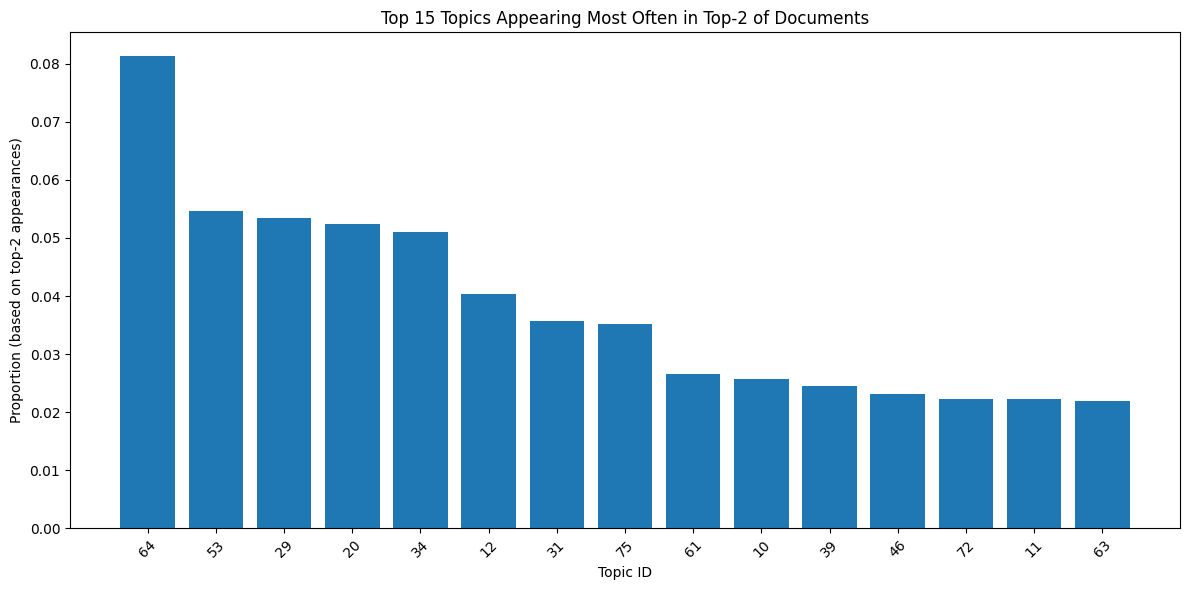

In [30]:
# ============================================================================
# Compute topic frequencies based on top2_topics_list
# ============================================================================

num_topics = best_k
topic_counts = np.zeros(num_topics)

# top2_topics_list = list of length n_docs
# each element = list of the 2 tuples (topic_id, probability)

for doc in top2_topics_list:
    for topic_id, prob in doc:
        topic_counts[topic_id] += 1   # Count appearances

# Convert counts into proportions
topic_proportions = topic_counts / topic_counts.sum()

# Create DataFrame for sorting
df_top2 = pd.DataFrame({
    "topic_id": range(num_topics),
    "count": topic_counts,
    "proportion": topic_proportions
})

# Select the top 15 topics
top15 = df_top2.sort_values("count", ascending=False).head(15)

print("\nTop 15 most frequent topics based on top-2 appearances:")
print(top15)

# ============================================================================
# Visualization
# ============================================================================

plt.figure(figsize=(12, 6))
plt.bar(top15["topic_id"].astype(str), top15["proportion"])
plt.xlabel("Topic ID")
plt.ylabel("Proportion (based on top-2 appearances)")
plt.title("Top 15 Topics Appearing Most Often in Top-2 of Documents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
